# INTRODUCCIÓN AL ANÁLISIS EXPLORATORIO DE TEXTO

## ANÁLISIS DE CONTENIDO

El análisis de contenido es una herramienta no intrusiva y que no tiene un impacto en como las personas se comportan. Describe como usar el libro como guía en un curso dependiendo el enfoque. Parte del conocimiento de expertos que pueden extraer el significado de los textos. 

Las computadoras pueden ayudar, pero el ejercicio analítico sigue siendo del investigador.

### _**"Prácticamente todas las disciplinas dentro del espectro completo de las humanidades y las ciencias sociales, incluidas aquellas que buscan mejorar las condiciones políticas y sociales de vida, se preocupan por las funciones y efectos de símbolos, significados y mensajes. En los últimos años, el surgimiento de la sociedad de la información ha desplazado a la minucias de comunicación (textos, contextos, imágenes, interfaces y, sobre todo, información) en el centro mismo de los intentos de los investigadores por lograr la autocomprensión".**_
- Krippendorff, 2019

El análisis de contenido nace de una intención de identificar significado de los mensajes. El contenido de análisis es un técnica de investigación replicable y que permite llegar a inferencias validas del texto en base a su contexto.

### _**"Los análisis de contenido tienen más éxito cuando se centran en hechos que se constituyen en el lenguaje, en los usos de los mismos textos que los analistas de contenido están analizando".**_
- Krippendorff, 2019

Nelson propone en su artículo un nuevo diseño de investigación iterativo en el que se mezcla técnicas computacionales con abordajes cualitativos para fortalecer los procesos de investigación social. El diseño consiste en 3 pasos iterativos moviendose entre herramientas computacionales y cualitativas para fortalecer los resultados. En la sesión de hoy utilizaremos herramientas que nos permiten explorar el contenido para identificar ideas en el contenido.  Utilizaremos la base de datos de discursos de la casa de los comunes en el Reino Unido. 

## IMPORTACIÓN DE HERRAMIENTAS

In [8]:
import pickle
from pprint import pprint
import pandas as pd
pd.set_option("display.notebook_repr_html", False)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from dcss.text import bigram_process, preprocess, bow_to_df
from dcss.plotting import format_axes_commas, custom_seaborn
from dcss.utils import sparse_groupby
custom_seaborn()
import spacy
nlp = spacy.load('en_core_web_sm')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
import scipy

In [9]:
columns = ['speech', 'speakername', 'party', 'constituency', 'year']
uk_df = pd.read_csv("../data/hansard-speeches-v301.csv")
uk_df.dropna(subset = ['party', 'speakername', 'speech'],inplace=True)
uk_df = uk_df.query('year > 2016')
uk_df['party'].value_counts()

Conservative                         1875
Scottish National Party              1768
Liberal Democrat                     1759
Labour                               1542
Democratic Unionist Party             961
Independent                           483
Labour (Co-op)                        341
Plaid Cymru                           247
Green Party                            96
The Independent Group for Change       39
Social Democratic & Labour Party       37
Ulster Unionist Party                  29
Change UK - The Independent Group      28
UK Independence Party                   3
Alliance                                1
Name: party, dtype: int64

In [10]:
parties_keep = [
    'Conservative',
    'Labour',
    'Scottish National Party',
    'Labour (Co-op)',
    'Liberal Democrat',
    'Democratic Unionist Party',
    'Plaid Cymru',
    'Green Party'
]
party_subset = uk_df[uk_df['party'].isin(parties_keep)].copy()
party_subset.reset_index(drop=True, inplace=True)
total_speech_counts = party_subset['party'].value_counts()
total_speech_counts

Conservative                 1875
Scottish National Party      1768
Liberal Democrat             1759
Labour                       1542
Democratic Unionist Party     961
Labour (Co-op)                341
Plaid Cymru                   247
Green Party                    96
Name: party, dtype: int64

In [17]:
sampled_speeches = party_subset.groupby('party').sample(replace=False, frac=.3, random_state=23)
len(sampled_speeches)

2576

In [18]:
with open('../data/pickles/sampled_british_hansard_speeches.pkl', 'wb') as fp:
    pickle.dump(sampled_speeches, fp)
sampled_speech_counts = sampled_speeches['party'].value_counts()
sample_sizes = pd.DataFrame(zip(total_speech_counts,sampled_speech_counts), columns=['Total', 'Sample'], index=parties_keep)

In [19]:
sampled_speeches['speech_len'] = sampled_speeches['speech'].apply(lambda x: len(x.split(" ")))

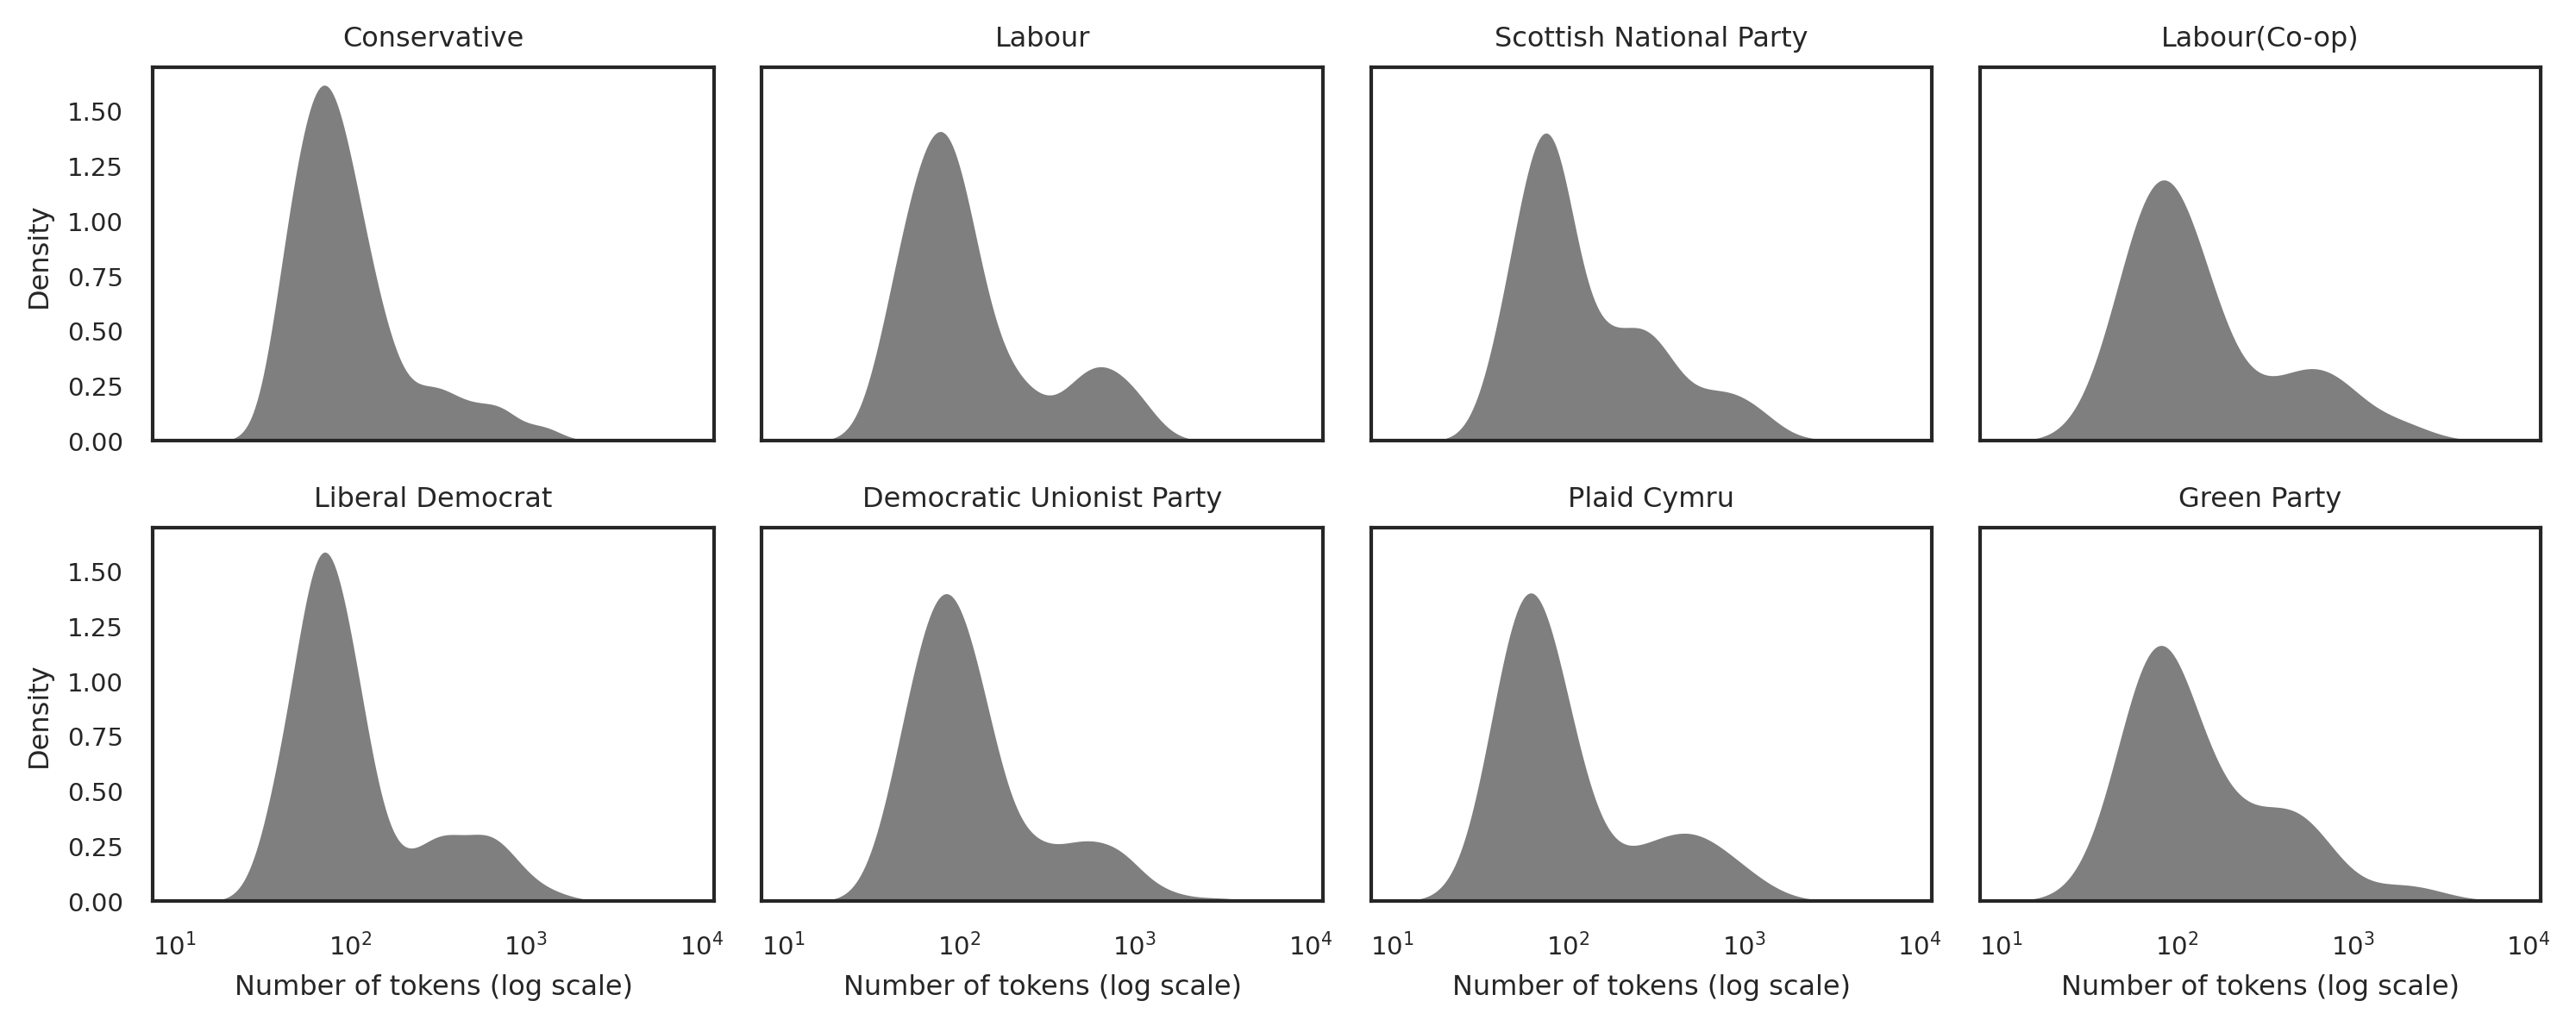

In [20]:
parties = sampled_speeches.groupby('party')
def party_subplot(subgroup, title, position):
    sns.kdeplot(ax = position, data=subgroup, x='speech_len', log_scale=True, fill=True, alpha=.5, linewidth=0, color='black') 
    position.set(xlabel='Number of tokens (log scale)', title=title)
fig, ax = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(10, 4))
    
party_subplot(parties.get_group('Conservative'), 'Conservative', ax[0,0])
party_subplot(parties.get_group('Labour'), 'Labour', ax[0,1])
party_subplot(parties.get_group('Scottish National Party'), 'Scottish National Party', ax[0,2])
party_subplot(parties.get_group('Labour (Co-op)'), 'Labour(Co-op)', ax[0,3])
party_subplot(parties.get_group('Liberal Democrat'),'Liberal Democrat', ax[1,0])
party_subplot(parties.get_group('Democratic Unionist Party'), 'Democratic Unionist Party', ax[1,1])
party_subplot(parties.get_group('Plaid Cymru'), 'Plaid Cymru', ax[1,2])
party_subplot(parties.get_group('Green Party'), 'Green Party', ax[1,3])

plt.tight_layout()
plt.show()